In [1]:
import numpy as np
import mne
import matplotlib.pyplot as plt
import pandas as pd
import os
import fnmatch
from sklearn.cluster import KMeans
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from scipy.fft import fft
from scipy.signal import blackman, hamming, detrend


import vitaldb

bis_eeg.shape (2686644, 2)
[[nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]]


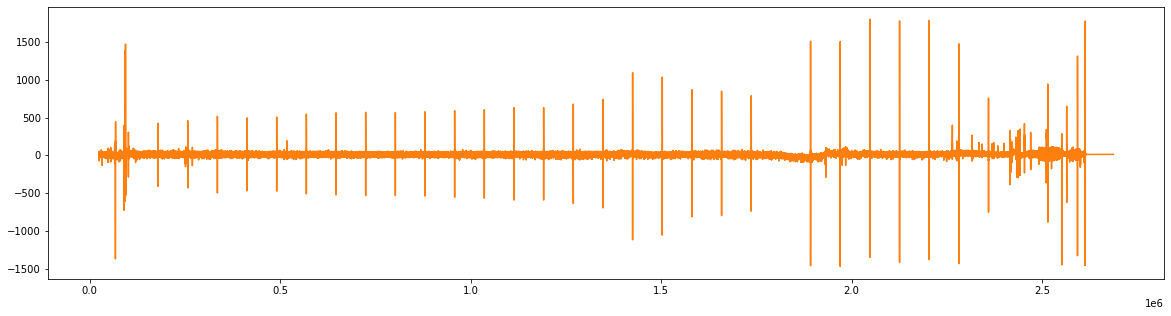

In [74]:
# 将dataset中的数据写入csv中
for i in range(4, 11):
    ipath = i

    # track_names = ['BIS/BIS', 'BIS/EMG', 'BIS/SEF', 'BIS/SQI', 'BIS/SR', 'BIS/TOTPOW']
    # track_names = ['BIS/TOTPOW']
    # track_names = ['BIS/BIS', 'BIS/SQI']
    # vf = vitaldb.VitalFile(ipath, track_names)
    # bis_data = vf.to_numpy(track_names, 1)
    # print('bis_data.shape', bis_data.shape)
    # print(bis_data[0:10, :])

    track_names = ['BIS/EEG1_WAV', 'BIS/EEG2_WAV']
    vf = vitaldb.VitalFile(ipath, track_names)
    bis_eeg = vf.to_numpy(track_names, 1/128)
    print('bis_eeg.shape', bis_eeg.shape)
    print(bis_eeg[0:10, :])

    plt.figure(figsize=(20, 5))
    plt.plot(bis_eeg[:, 0])
    plt.plot(bis_eeg[:, 1])
    plt.show()

    data_csv = {}
    data_csv['eeg1'] = bis_eeg[:, 0]
    data_csv['eeg2'] = bis_eeg[:, 1]
    # data_df = pd.DataFrame(data_csv)
    # data_df.to_csv('../vitalDB/data_20/{}_eeg.csv'.format(ipath))

In [ ]:
# vitaldb.vital_trks(ipath)
# vitaldb.vital_recs(ipath, track_names=None, interval=None, return_timestamp=False, return_datetime=False, return_pandas=False, exclude=None)
# vitaldb.VitalFile(ipath, track_names=None, caseids=None, skip_records=False, exclude=None, userid=None)
# vitaldb.VitalFile.crop(dtfrom=None, dtend=None)
# vitaldb.VitalFile.get_track_names()


In [ ]:
# 可以先尝试 双频谱 + K-means clustering

eeg_data.shape (2, 1477261)
duration (s):  11541.1015625
eeg_data_seg.shape (11541, 2, 128)


In [2]:
# 将EEG切分成1s的片段
def eeg_segment(eeg_data, fs):
    seg_points = 1 * fs
    seg_num = eeg_data.shape[1] // seg_points
    eeg_data = eeg_data[:, 0:seg_points*seg_num]
    # eeg_data = eeg_data.reshape((len(label), eeg_data.shape[0], -1))
    eeg_data_seg = eeg_data.reshape((eeg_data.shape[0], -1, seg_points))
#     print('eeg_data.shape', eeg_data.shape)
    eeg_data_seg = eeg_data_seg.transpose(1,0,2)
    print('eeg_data_seg.shape', eeg_data_seg.shape)
    return eeg_data_seg

In [3]:
# 存在bis长度和EEG长度不匹配的问题，先按照开头对齐处理
def delete_nan(eeg_data, bis_bis):
    tmp1 = (np.sum(np.sum(np.isnan(eeg_data), axis=-1), axis=-1) == 0)
    # print(tmp)
    tmp2 = np.isnan(bis_bis)
    tmp = tmp1[0:min(tmp1.shape[0], tmp2.shape[0])] & (~tmp2[0:min(tmp1.shape[0], tmp2.shape[0])])
    eeg_data = eeg_data[0:min(tmp1.shape[0], tmp2.shape[0])]
    bis_bis = bis_bis[0:min(tmp1.shape[0], tmp2.shape[0])]
    eeg_data_clean = eeg_data[tmp]
    bis_bis_clean = bis_bis[tmp]
    print('eeg_data_clean.shape', eeg_data_clean.shape)
    print('bis_bis_clean.shape', bis_bis_clean.shape)
    return eeg_data_clean, bis_bis_clean

In [4]:
# 基于阈值的噪声检测 & 去除
def artifact_removal(eeg_data, bis_bis):
    T = 100
    tmp = (np.sum(np.sum((eeg_data > T), axis=-1), axis=-1) == 0)
    eeg_data = eeg_data[tmp]
    bis_bis = bis_bis[tmp]
    print('[artifact removal] eeg_data.shape', eeg_data.shape)
    return eeg_data, bis_bis


In [5]:
def get_bispectrum(eeg_data):
    L = 1
    w = hamming(eeg_data.shape[-1])
    ywf = fft(w * detrend(eeg_data, type='constant'))
    print(ywf.shape)
    bispectrum = np.zeros((ywf.shape[0], ywf.shape[1], ywf.shape[2]//2, ywf.shape[2]//2))
    for i in range(bispectrum.shape[-2]):
        for j in range(bispectrum.shape[-1]):
            bispectrum[:,:,i,j] = np.abs(ywf[:,:,i] * ywf[:,:,j] * np.conj(ywf[:,:,i+j]))
    return bispectrum


In [62]:
def get_trispectrum(eeg_data):
    L = 1
    w = hamming(eeg_data.shape[-1])
    ywf = fft(w * detrend(eeg_data, type='constant'))
    print('ywf.shape', ywf.shape)
    trispectrum = np.zeros((ywf.shape[0], ywf.shape[1], ywf.shape[2]//3, ywf.shape[2]//3, ywf.shape[2]//3))
    for i in range(trispectrum.shape[-3]):
        for j in range(trispectrum.shape[-2]):
            for k in range(trispectrum.shape[-1]):
                trispectrum[:,:,i,j,k] = np.abs(ywf[:,:,i] * ywf[:,:,j] * ywf[:,:,k] * 
                                                np.conj(ywf[:,:,i+j]) * np.conj(ywf[:,:,i+k]) * np.conj(ywf[:,:,j+k]) * ywf[:,:,i+j+k])
    return trispectrum
trispectrum = get_trispectrum(eeg_data)
print(trispectrum.shape)

(11044, 2, 128)
(11044, 2, 42, 42, 42)


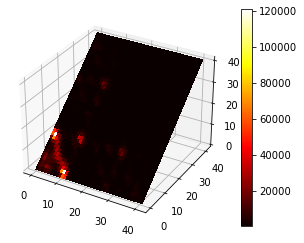

In [86]:
# 尝试用颜色代表第四个维度 没有画出来
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

x = 10 * np.outer(np.cos(u), np.sin(v))
y = 10 * np.outer(np.sin(u), np.sin(v))
z = 10 * np.outer(np.ones(np.size(u)), np.cos(v))
z1 = z * np.cos(0.5*x)

N = z1 / z1.max() # normalize 0..1

xx = np.arange(0,42,1)
yy = np.arange(0,42,1)
zz = np.arange(0,42,1)
x, y = np.meshgrid(xx, yy)
x, z = np.meshgrid(xx, zz)
z1 = trispectrum[0,0,1,:,:]
N = z1 / z1.max() # normalize 0..1

#plt.cm.颜色类型
surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=plt.cm.hot(N), linewidth=0, antialiased=False, shade=False)

m = plt.cm.ScalarMappable(cmap=plt.cm.hot)
m.set_array(z1)
plt.colorbar(m)
plt.show()

In [83]:
N.shape

(100, 100)

In [71]:
print(help(np.outer))

Help on function outer in module numpy:

outer(a, b, out=None)
    Compute the outer product of two vectors.
    
    Given two vectors, ``a = [a0, a1, ..., aM]`` and
    ``b = [b0, b1, ..., bN]``,
    the outer product [1]_ is::
    
      [[a0*b0  a0*b1 ... a0*bN ]
       [a1*b0    .
       [ ...          .
       [aM*b0            aM*bN ]]
    
    Parameters
    ----------
    a : (M,) array_like
        First input vector.  Input is flattened if
        not already 1-dimensional.
    b : (N,) array_like
        Second input vector.  Input is flattened if
        not already 1-dimensional.
    out : (M, N) ndarray, optional
        A location where the result is stored
    
        .. versionadded:: 1.9.0
    
    Returns
    -------
    out : (M, N) ndarray
        ``out[i, j] = a[i] * b[j]``
    
    See also
    --------
    inner
    einsum : ``einsum('i,j->ij', a.ravel(), b.ravel())`` is the equivalent.
    ufunc.outer : A generalization to dimensions other than 1D and other
 

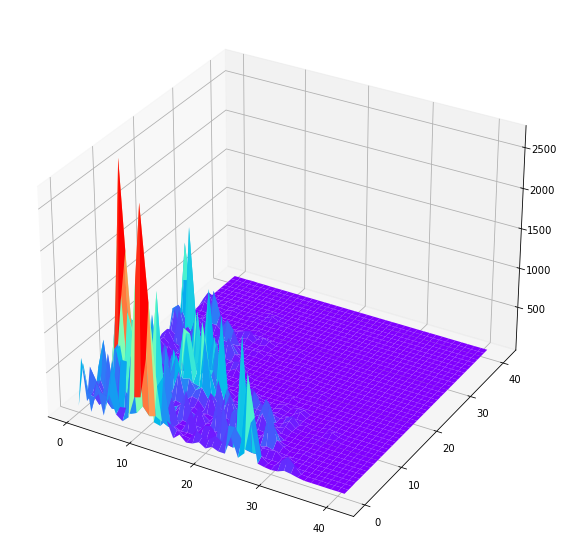

In [109]:
fig = plt.figure()  #定义新的三维坐标轴
ax3 = plt.axes(projection='3d')

#定义三维数据
# f_max = 64
f_max = 42
xx = np.arange(0,f_max,1)
yy = np.arange(0,f_max,1)
X, Y = np.meshgrid(xx, yy)
# Z = bispectrum[0,0,:,:]
Z = trispectrum[0,0,:,:,13]
#作图
ax3.plot_surface(X, Y, Z, cmap='rainbow')
fig.set_size_inches(10, 10)
# plt.savefig('figs/feature/bispectrum.png', dpi=300)
plt.savefig('figs/feature/trispectrum.png', dpi=300)
plt.show()

In [6]:
# 读取csv中的数据 (前面的用vitalDB直接读数据方法本质上是在线下载，比较慢)
path_root = '../vitalDB/data_20'
eeg_ch_num = 2
sub_num = 10
fs = 128
# for i in range(sub_num):
for i in range(1):
# for i in [2,5]:
    df = pd.read_csv('{}/{}_eeg.csv'.format(path_root, i + 1))
    tmp_L = len(df['eeg1'])
    eeg_data = np.zeros((eeg_ch_num, tmp_L))
    for j in range(eeg_data.shape[0]):
        eeg_data[j, :] = np.array(df['eeg{}'.format(j+1)].tolist())

    # plt.figure(figsize=(20, 5))
    # plt.plot(eeg_data[0])
    # plt.show()
    # plt.figure(figsize=(20, 5))
    # plt.plot(eeg_data[1])
    # plt.show()

    df = pd.read_csv('{}/{}.csv'.format(path_root, i + 1))
    bis_bis = np.array(df['BIS/BIS'].tolist())
    print('bis_bis.shape', bis_bis.shape)
    
    print('eeg_data.shape', eeg_data.shape)
    print('duration (s): ', eeg_data.shape[1]/fs)
    eeg_data = eeg_segment(eeg_data, fs)
    eeg_data, bis_bis = delete_nan(eeg_data, bis_bis)
    eeg_data, bis_bis = artifact_removal(eeg_data, bis_bis)
    # eeg_data = eeg_data.reshape((eeg_data.shape[0], -1))
    print('eeg_data.shape', eeg_data.shape)

    # 得到双谱特征
    bispectrum = get_bispectrum(eeg_data)
    print('bispectrum.shape', bispectrum.shape)



bis_bis.shape (11521,)
eeg_data.shape (2, 1477261)
duration (s):  11541.1015625
eeg_data_seg.shape (11541, 2, 128)
eeg_data_clean.shape (11518, 2, 128)
bis_bis_clean.shape (11518,)
[artifact removal] eeg_data.shape (11044, 2, 128)
eeg_data.shape (11044, 2, 128)
(11044, 2, 128)
bispectrum.shape (11044, 2, 64, 64)


In [46]:
def normlization_new(data):
    for i in range(data.shape[0]):
        data[i] = (data[i] - np.mean(data[i])) / np.std(data[i])
    return data

得分: -6.866357061025956


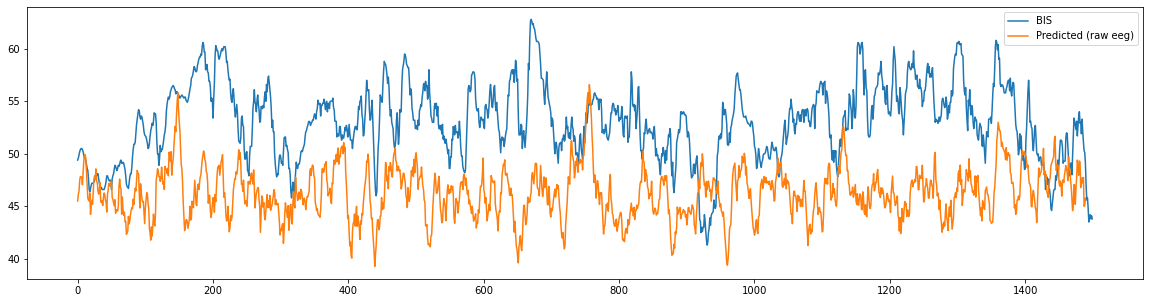

得分: -7.6918093459597205


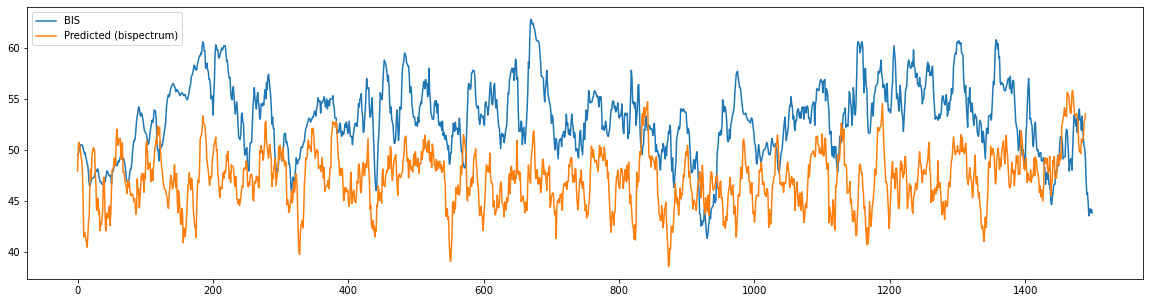

得分: -5.805511461811234


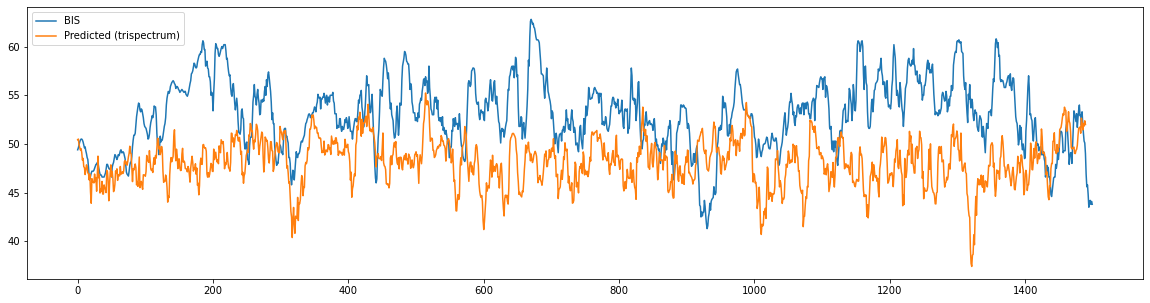

In [105]:
clf = SVR(kernel='rbf', C=500, gamma='auto', max_iter=500000)
x_train, x_test, y_train, y_test = train_test_split(normlization_new(eeg_data.reshape((eeg_data.shape[0], -1))[2000:8000]), 
                                                    bis_bis[2000:8000], test_size=0.25, shuffle=False)
clf.fit(x_train, y_train)
y_hat = clf.predict(x_test)

print("得分:", r2_score(y_test, y_hat))

plt.figure(figsize=(20, 5))
plt.plot(y_test, label='BIS')
y_pred = np.zeros(y_hat.shape[0]-10)
for i in range(y_pred.shape[0]):
    y_pred[i] = np.mean(y_hat[i:(i+10)])
plt.plot(y_pred, label='Predicted (raw eeg)')
plt.legend()
plt.savefig('figs/feature/raw_eeg-bis.png', dpi=300)
plt.show()

feature = bispectrum[2000:8000]
feature = feature[:, :, 0:10, 0:10]
feature = feature.reshape((feature.shape[0], -1))
x_train, x_test, y_train, y_test = train_test_split(normlization_new(feature), bis_bis[2000:8000], test_size=0.25, shuffle=False)
clf.fit(x_train, y_train)
y_hat = clf.predict(x_test)

print("得分:", r2_score(y_test, y_hat))

plt.figure(figsize=(20, 5))
plt.plot(y_test, label='BIS')
y_pred = np.zeros(y_hat.shape[0]-10)
for i in range(y_pred.shape[0]):
    y_pred[i] = np.mean(y_hat[i:(i+10)])
plt.plot(y_pred, label='Predicted (bispectrum)')
plt.legend()
plt.savefig('figs/feature/bispectrum-bis.png', dpi=300)
plt.show()

feature = trispectrum[2000:8000]
feature = feature[:, :, 0:5, 0:5, 0:5]
feature = feature.reshape((feature.shape[0], -1))
x_train, x_test, y_train, y_test = train_test_split(normlization_new(feature), bis_bis[2000:8000], test_size=0.25, shuffle=False)
clf.fit(x_train, y_train)
y_hat = clf.predict(x_test)

print("得分:", r2_score(y_test, y_hat))

plt.figure(figsize=(20, 5))
plt.plot(y_test, label='BIS')
y_pred = np.zeros(y_hat.shape[0]-10)
for i in range(y_pred.shape[0]):
    y_pred[i] = np.mean(y_hat[i:(i+10)])
plt.plot(y_pred, label='Predicted (trispectrum)')
plt.legend()
plt.savefig('figs/feature/trispectrum-bis.png', dpi=300)
plt.show()

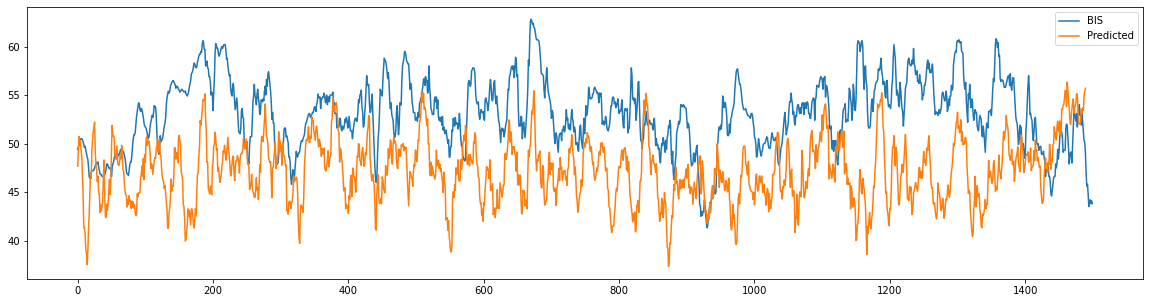

In [57]:
plt.figure(figsize=(20, 5))
plt.plot(y_test, label='BIS')
y_pred = np.zeros(y_hat.shape[0]-10)
for i in range(y_pred.shape[0]):
    y_pred[i] = np.mean(y_hat[i:(i+10)])
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()
# print(help(train_test_split))

In [23]:
# print(x_train[0])
# print(eeg_data[0])
print(y_train[0:10])
print(y_test[-500:-400])
print(bis_bis[0:10])
print(bis_bis[-500:-400])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[76.9 76.6 76.9 77.1 77.3 77.4 77.6 77.6 77.3 76.9 76.9 76.8 76.9 76.6
 76.6 76.6 77.1 76.5 76.6 76.9 77.1 76.9 77.2 77.6 77.8 77.8 77.7 78.5
 79.4 79.4 79.1 78.8 79.4 79.6 79.  78.3 76.6 76.7 77.  76.9 76.9 77.2
 77.2 77.3 77.7 78.2 77.9 77.9 78.4 78.9 78.  77.8 77.6 77.4 77.3 77.2
 76.9 76.9 76.7 76.5 76.6 76.7 76.9 76.8 76.7 76.8 77.3 77.4 77.  77.1
 77.2 77.2 77.1 77.2 77.4 77.1 77.4 77.8 78.  77.9 77.7 77.8 77.8 77.8
 78.2 78.  78.7 78.3 80.2 79.7 80.4 80.5 78.  78.1 78.3 78.  77.8 77.8
 77.9 77.6]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[76.9 76.6 76.9 77.1 77.3 77.4 77.6 77.6 77.3 76.9 76.9 76.8 76.9 76.6
 76.6 76.6 77.1 76.5 76.6 76.9 77.1 76.9 77.2 77.6 77.8 77.8 77.7 78.5
 79.4 79.4 79.1 78.8 79.4 79.6 79.  78.3 76.6 76.7 77.  76.9 76.9 77.2
 77.2 77.3 77.7 78.2 77.9 77.9 78.4 78.9 78.  77.8 77.6 77.4 77.3 77.2
 76.9 76.9 76.7 76.5 76.6 76.7 76.9 76.8 76.7 76.8 77.3 77.4 77.  77.1
 77.2 77.2 77.1 77.2 77.4 77.1 77.4 77.8 78.  77.9 77.7 77.8 77.8 77.8
 

In [8]:
print(help(KMeans))

Help on class KMeans in module sklearn.cluster._kmeans:

class KMeans(sklearn.base.TransformerMixin, sklearn.base.ClusterMixin, sklearn.base.BaseEstimator)
 |  KMeans(n_clusters=8, *, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='deprecated', verbose=0, random_state=None, copy_x=True, n_jobs='deprecated', algorithm='auto')
 |  
 |  K-Means clustering.
 |  
 |  Read more in the :ref:`User Guide <k_means>`.
 |  
 |  Parameters
 |  ----------
 |  
 |  n_clusters : int, default=8
 |      The number of clusters to form as well as the number of
 |      centroids to generate.
 |  
 |  init : {'k-means++', 'random'}, callable or array-like of shape             (n_clusters, n_features), default='k-means++'
 |      Method for initialization:
 |  
 |      'k-means++' : selects initial cluster centers for k-mean
 |      clustering in a smart way to speed up convergence. See section
 |      Notes in k_init for more details.
 |  
 |      'random': choose `n_clusters` o

In [112]:
# X = np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0]])
# kmeans = KMeans(n_clusters=5, random_state=0, n_init=10).fit(eeg_data.reshape((eeg_data.shape[0], -1)))
kmeans = KMeans(n_clusters=100, random_state=0, n_init=10).fit(bispectrum.reshape((bispectrum.shape[0], -1)))
print(kmeans.labels_)

# kmeans.predict([[0, 0], [12, 3]])

print(kmeans.cluster_centers_)

[70 70 70 ... 70 70 70]
[[6.95901425e+06 1.65792701e+07 5.58606053e+06 ... 5.01840134e+02
  2.74769957e+02 9.41761424e+02]
 [1.17579391e+10 4.35128562e+10 5.61022458e+10 ... 2.06035661e+03
  2.37697023e+02 3.50337831e+03]
 [1.01344784e+10 2.94030757e+10 4.76473625e+10 ... 5.32987394e+02
  1.90472493e+02 2.25553726e+02]
 ...
 [8.60088255e+07 1.44934724e+08 2.44242910e+07 ... 4.85740741e+02
  1.94653872e+02 5.83334859e+02]
 [1.30167296e+08 1.44639413e+08 8.91888708e+06 ... 4.53931951e+03
  1.17104909e+03 9.84444317e+02]
 [2.80629667e+07 1.08493558e+08 3.57064178e+07 ... 6.93972481e+02
  2.29302773e+02 3.14231657e+02]]


In [83]:
def cnt_labels(label, n_class):
    cnt = np.zeros(n_class)
    for i in range(label.shape[0]):
        cnt[label[i]] += 1
    return cnt

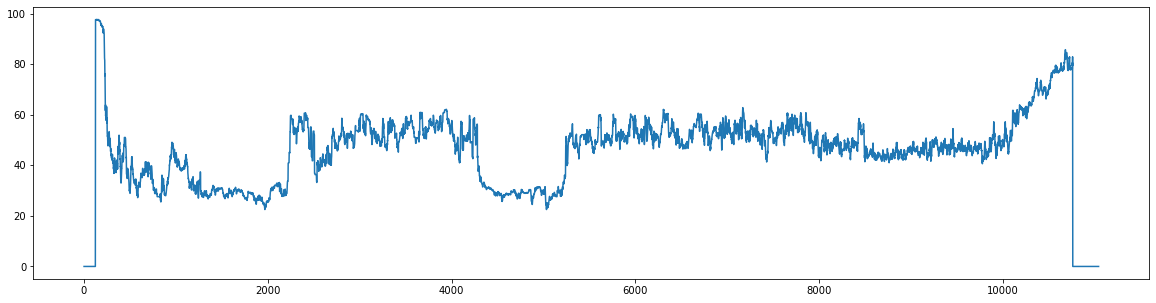

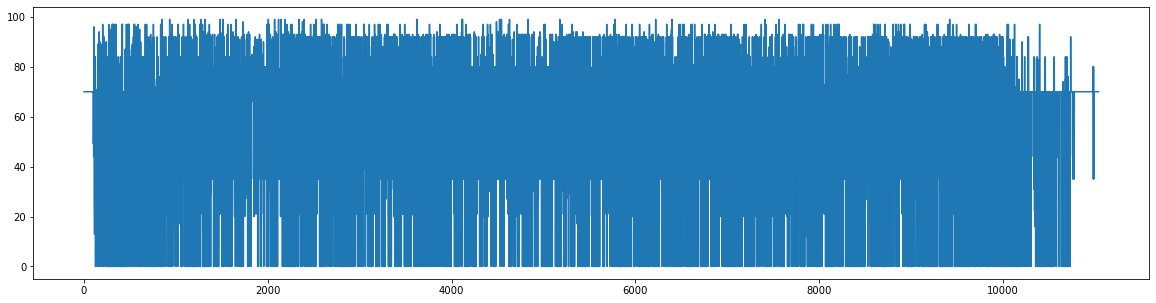

In [113]:
plt.figure(figsize=(20, 5))
plt.plot(bis_bis)
plt.show()

# bis_bis_quan = bis_bis // 20
# plt.figure(figsize=(20, 5))
# plt.plot(bis_bis_quan)
# plt.show()

plt.figure(figsize=(20, 5))
plt.plot(kmeans.labels_)
plt.show()

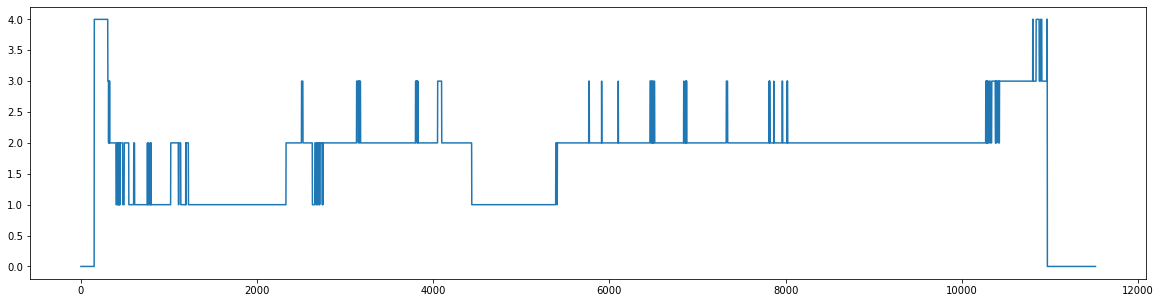

In [54]:
bis_bis_quan = bis_bis // 20
plt.figure(figsize=(20, 5))
plt.plot(bis_bis_quan)
plt.show()

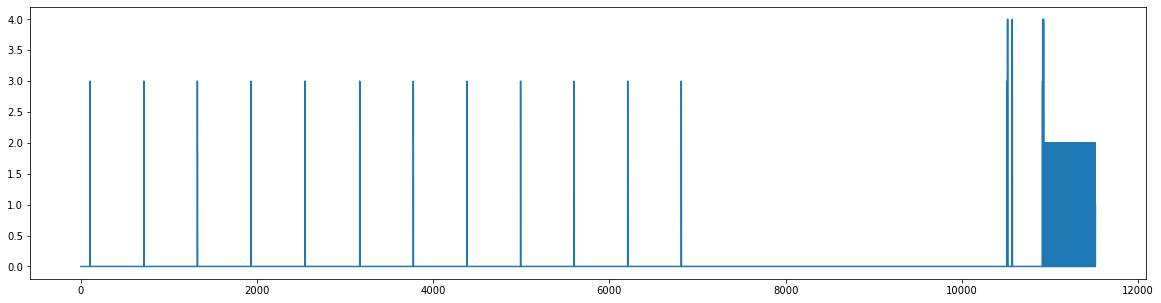

In [55]:
plt.figure(figsize=(20, 5))
plt.plot(kmeans.labels_)
plt.show()

In [114]:
print(cnt_labels(kmeans.labels_, 100))

[1.200e+03 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 2.000e+01 1.000e+00 1.000e+00 7.500e+01
 1.310e+02 1.000e+00 3.000e+00 1.000e+00 1.000e+00 5.000e+00 6.600e+01
 1.000e+00 5.600e+01 1.700e+01 3.400e+01 4.000e+00 1.900e+01 7.000e+00
 1.441e+03 1.000e+00 2.000e+00 3.200e+01 2.600e+01 3.150e+02 4.400e+01
 6.000e+00 3.000e+00 1.880e+02 4.800e+01 7.500e+01 4.710e+02 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.340e+02 1.000e+01 1.450e+02
 3.000e+00 1.000e+00 4.900e+01 2.640e+02 3.000e+00 1.200e+01 3.600e+01
 5.000e+00 7.000e+00 7.500e+01 3.900e+01 1.300e+01 1.000e+00 4.000e+00
 2.963e+03 1.000e+00 3.500e+01 9.700e+01 2.400e+01 2.670e+02 1.610e+02
 1.200e+01 1.000e+00 1.380e+02 3.890e+02 4.200e+01 1.000e+00 2.000e+00
 3.830e+02 1.100e+01 1.000e+00 1.500e+01 1.510e+02 2.300e+01 5.800e+01
 1.170e+02 6.540e+02 1.670e+02 2.700e+01 4.000e+00 2.000e+00 1.460e+02
 3.000

In [26]:
print(np.sum(kmeans.labels_))

455
